# <font color='black'> Project group: </font>
Nicholas Butt, Abby Tien, and Camryn MacDougall

In [47]:
import pandas as pd
import csv
import math
import numpy as np
import scipy 
from scipy import stats as sts
from scipy.stats import norm
from numpy.random import default_rng
from numpy.random import choice
import matplotlib.pyplot as plt
from plotnine import *
import weakref

vir1 = '#FDE725FF'
vir2 = '#238A8DFF'
vir3 = '#55C667FF'
vir4 = '#404788FF'

rng = default_rng(13)

In [33]:
# defining agent classes
class Physician():
    def __init__(self):
        self.phy_age = 0
        self.phy_capacity = 0
        self.phy_remove = False  # this counts as physicians closing practice or retiring
        self.phy_ID = 0
        self.patient_IDs = []
        self.original_phy = False

    def getPhyAttributes(self):
        return [self.phy_age, self.phy_capacity, self.phy_remove, self.phy_ID, self.patient_IDs, self.original_phy]

    def initPhyAttributes(self, new_phy=False, phy_ID=0):
        if new_phy == False:
            age_group = choice([0, 1, 2, 3, 4], 1, p=[0.1, 0.23, 0.25, 0.26, 0.16])
            if age_group == 0:  # under 35 age group
                self.phy_age = np.random.randint(30, 35)  # note: high is exclusive
            elif age_group == 1:  # 35 to 44 age group
                self.phy_age = np.random.randint(35, 45)
            elif age_group == 2:  # 45 to 54 age group
                self.phy_age = np.random.randint(45, 55)
            elif age_group == 3:  # 55 to 64 age group
                self.phy_age = np.random.randint(55, 65)
            else:
                self.phy_age = np.random.randint(65, 70)
        else:
            self.phy_age = 28  # starting physician age
        self.phy_ID = phy_ID
        self.phy_capacity = 2500  # from source
        
    def setPhyAttributes(self, attrib, value):
        if attrib == 'phy_capacity':
            self.phy_capacity = value
        elif attrib == 'patient_ID':
            self.patient_IDs.append(value)
        elif attrib == 'original_phy':
            self.original_phy = value
        else:
            print('Unknown patient attribute')

    def stepPhy(self):
        self.phy_age += 1
        if self.phy_age >= 65:
            if choice([0, 1], 1, p=[0.84, 1-0.84]) == 0:  # 84% chance to retire after age 65
                self.phy_remove = True
        
        # note: not updating capacity with age right now for simplicity
        

In [3]:
class Patient():
    def __init__(self):
        self.pat_age = -1
        self.has_phy = False
        self.pat_death_prob = 0
        self.pat_ID = 0
        self.physician_ID = 0

    def getPatAttributes(self):
        return [self.pat_age, self.has_phy, self.pat_death_prob, self.pat_ID, self.physician_ID]

    def initPatAttributes(self, pat_ID=0):
        # note: self.has_phy gets updated within the simulation (always false on init)
        self.pat_ID = pat_ID
        self.pat_age = np.random.randint(0, 85)
        if self.pat_age < 40:
            self.pat_death_prob = 0
        elif 39 < self.pat_age < 60:
            self.pat_death_prob = 0.04
        elif 59 < self.pat_age < 80:
            self.pat_death_prob = 0.075
        else:
            self.pat_death_prob = 0.086
    
    def setPatAttributes(self, attrib, value):
        if attrib == 'has_phy':
            self.has_phy = value
        elif attrib == 'pat_death_prob':
            self.pat_death_prob = value
        elif attrib == 'physician_ID':
            self.physician_ID = value
        else:
            print('Unknown patient attribute')

    def stepPat(self):
        self.pat_age += 1
        
        if self.pat_age < 40:
            self.pat_death_prob = 0
        elif 39 < self.pat_age < 60:
            if self.has_phy:
                self.pat_death_prob = 0.04/2
            else:
                self.pat_death_prob = 0.04
        elif 59 < self.pat_age < 80:
            if self.has_phy:
                self.pat_death_prob = 0.075/2
            else:
                self.pat_death_prob = 0.075
        else:
            if self.has_phy:
                self.pat_death_prob = 0.086/2
            else:
                self.pat_death_prob = 0.086
        


In [39]:
# physician availability model
def step_simulation(list_pat, list_phy, timestep):
    pat_removal_IDs = []
    pat_lost_phy_IDs = []  # the IDs of the patients now without a physician
    phy_lost_pat_IDs = []  # the IDs of the physicians that lost a patient
    for phy in list_phy:
        phy.stepPhy()
        if phy.getPhyAttributes()[2] == True:
            pat_lost_phy_IDs.append(phy.getPhyAttributes()[4])
            list_phy.remove(phy)
        elif phy.getPhyAttributes()[5] == True:
            if timestep == 0:  # 2024 timestep
                if choice([0, 1], 1, p=[0.05, 0.95]) == 0:
                    pat_lost_phy_IDs.append(phy.getPhyAttributes()[4])
                    list_phy.remove(phy)
            if timestep == 1 or timestep == 2:  # 2025 and 2026 timesteps
                if choice([0, 1], 1, p=[0.075, 0.925]) == 0:
                    pat_lost_phy_IDs.append(phy.getPhyAttributes()[4])
                    list_phy.remove(phy)

    for pat in list_pat:
        # checks if patients physician has retired
        if any(pat.getPatAttributes()[3] in sublist for sublist in pat_lost_phy_IDs) == True:
            pat.setPatAttributes('has_phy', False)
        pat.stepPat()
        # 0 means dying, 1 means stay alive
        if choice([0, 1], 1, p=[pat.getPatAttributes()[2], 1-pat.getPatAttributes()[2]]) == 0:
            phy_lost_pat_IDs.append(pat.getPatAttributes()[4])
            pat_removal_IDs.append(pat.getPatAttributes()[3])
            list_pat.remove(pat)

    for phy in list_phy:
        phy.setPhyAttributes('phy_capacity', phy.getPhyAttributes()[1] + phy_lost_pat_IDs.count(phy.getPhyAttributes()[3]))
        temp = 0
        for i in range(len(phy.getPhyAttributes()[4])):
            if phy.getPhyAttributes()[4][i-temp] in pat_removal_IDs:
                phy.getPhyAttributes()[4].remove(phy.getPhyAttributes()[4][i-temp])
                temp += 1

Realization 0 completed
Realization 1 completed
Realization 2 completed
Realization 3 completed
Realization 4 completed
Realization 5 completed
Realization 6 completed
Realization 7 completed
Realization 8 completed
Realization 9 completed
Realization 10 completed
Realization 11 completed
Realization 12 completed
Realization 13 completed
Realization 14 completed
Realization 15 completed
Realization 16 completed
Realization 17 completed
Realization 18 completed
Realization 19 completed
Realization 20 completed
Realization 21 completed
Realization 22 completed
Realization 23 completed
Realization 24 completed
Realization 25 completed
Realization 26 completed
Realization 27 completed
Realization 28 completed
Realization 29 completed
Realization 30 completed
Realization 31 completed
Realization 32 completed
Realization 33 completed
Realization 34 completed
Realization 35 completed
Realization 36 completed
Realization 37 completed
Realization 38 completed
Realization 39 completed
Realizatio

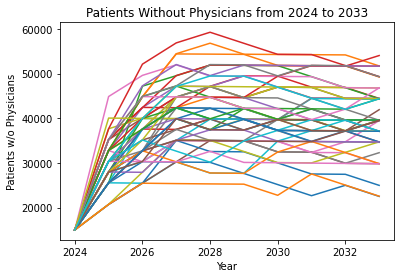

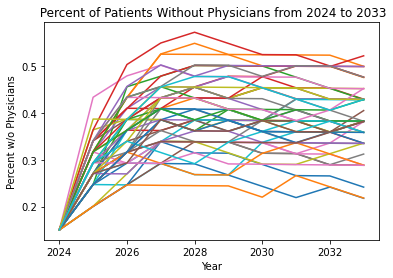

In [52]:
num_starting_pats = 100000  # scaling the ~3 million people in Toronto to 100000 for computational power reasons
pat_ID = 1
num_starting_phys = 34  # 34 physicians results in 15% of the "100000" people in Toronto not having a family physician 
phy_ID = 1

num_realizations = 50  # 50 simulation realizations for computational reasons
num_timesteps = 10  # 10 years of simulation

# data recording lists
pats_wo_phys = []
percent_wo_phys = []

for r in range(num_realizations):
    list_Patients = [Patient() for i in range(num_starting_pats)]
    for pat in list_Patients:
        pat.initPatAttributes(pat_ID=pat_ID)
        pat_ID += 1
    list_Physicians = [Physician() for i in range(num_starting_phys)]
    for phy in list_Physicians:
        phy.initPhyAttributes(phy_ID=phy_ID)
        phy_ID += 1
        phy.setPhyAttributes('original_phy', True)
    
    realization_pats_wo_phys = []
    realization_percent_wo_phys = []

    for t in range(num_timesteps):
        for phy in list_Physicians:
            if phy.getPhyAttributes()[0] == 0:
                phy.initPhyAttributes(phy_ID=phy_ID)
                phy_ID += 1
            for pat in list_Patients:
                if pat.getPatAttributes()[0] == -1:
                    pat.initPatAttributes()
                    pat_ID += 1
                if phy.getPhyAttributes()[1] > 0:
                    if pat.getPatAttributes()[1] == False:
                        # patient triage model
                        pat.setPatAttributes('has_phy', True)
                        pat.setPatAttributes('physician_ID', phy.getPhyAttributes()[3])
                        phy.setPhyAttributes('phy_capacity', phy.getPhyAttributes()[1]-1)
                        phy.setPhyAttributes('patient_ID', pat.getPatAttributes()[3])
        
        # recording data for each realization
        no_phy_count = 0
        for pat in list_Patients:
            if pat.getPatAttributes()[1] == False:
                no_phy_count += 1   
        realization_pats_wo_phys.append(no_phy_count)
        realization_percent_wo_phys.append(no_phy_count/len(list_Patients))
        
        if t != num_timesteps-1:  # do not step the simulation after triaging the last simulation year
            step_simulation(list_Patients, list_Physicians, t)
            # dividing by age range to keep physician population relatively constant
#             for i in range(choice([2, 3], 1, p=[0.5, 0.5]).item()):
            list_Physicians.append(Physician())  # 1 new physician per year as they make up approx. 1/30th of physicians
            for i in range(round(num_starting_pats*(1.003**(num_timesteps+1)))-len(list_Patients)):  # 1.003% population growth
                list_Patients.append(Patient())
                
    pats_wo_phys.append(realization_pats_wo_phys)
    percent_wo_phys.append(realization_percent_wo_phys)
    print(f'Realization {r} completed')

years = []
for i in range(10):
    years.append(i+2024)  # first simulated year is 2024
# print(pats_wo_phys)
# print()
# print(percent_wo_phys)
# print(years)

# for i in range(len(percent_wo_phys[0])):
#     print(list(pt for pt in percent_wo_phys))
#     plt.plot(years, [pt[i] for pt in percent_wo_phys])
# num_data = np.array(pats_wo_phys)
# plt.plot(years, pats_wo_phys)
# plt.show()

plt.figure()
plt.title('Patients Without Physicians from 2024 to 2033')
plt.xlabel('Year')
plt.ylabel('Patients w/o Physicians')
for i in range(num_realizations):
    plt.plot(years,pats_wo_phys[i])

plt.figure()
plt.title(' Percent of Patients Without Physicians from 2024 to 2033')
plt.xlabel('Year')
plt.ylabel('Percent w/o Physicians')
for i in range(num_realizations):
    plt.plot(years, percent_wo_phys[i])

plt.show()

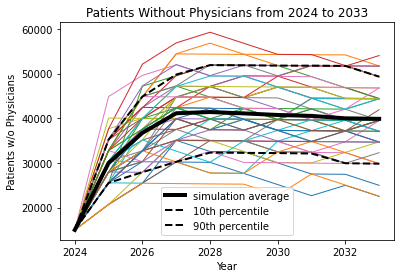

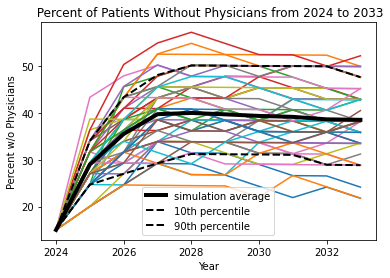

In [73]:
prc_percent_wo_phys = np.array(percent_wo_phys)*100
plt.figure()
plt.title('Patients Without Physicians from 2024 to 2033')
plt.xlabel('Year')
plt.ylabel('Patients w/o Physicians')
for i in range(50):
    plt.plot(years,pats_wo_phys[i], linewidth=1)
plt.plot(years, np.mean(pats_wo_phys, axis=0), linewidth=4, color='black', label='simulation average')
plt.plot(years, np.percentile(pats_wo_phys, 10, axis=0), '--', linewidth=2, color='black', label='10th percentile')
plt.plot(years, np.percentile(pats_wo_phys, 90, axis=0), '--', linewidth=2, color='black', label='90th percentile')
plt.legend()

plt.figure()
plt.title(' Percent of Patients Without Physicians from 2024 to 2033')
plt.xlabel('Year')
plt.ylabel('Percent w/o Physicians')
for i in range(50):
    plt.plot(years, prc_percent_wo_phys[i])
plt.plot(years, np.mean(prc_percent_wo_phys, axis=0), linewidth=4, color='black', label='simulation average')
plt.plot(years, np.percentile(prc_percent_wo_phys, 10, axis=0), '--', linewidth=2, color='black', label='10th percentile')
plt.plot(years, np.percentile(prc_percent_wo_phys, 90, axis=0), '--', linewidth=2, color='black', label='90th percentile')
plt.legend()

plt.show()

In [ ]:
# for situation 2

num_starting_pats = 100000  # scaling the ~3 million people in Toronto to 100000 for computational power reasons
pat_ID = 1
num_starting_phys = 34  # 34 physicians results in 15% of the "100000" people in Toronto not having a family physician 
phy_ID = 1

num_realizations = 50  #  simulation realizations for computational reasons
num_timesteps = 10  # 10 years of simulation

# data recording lists
sit2_pats_wo_phys = []
sit2_percent_wo_phys = []

for r in range(num_realizations):
    list_Patients = [Patient() for i in range(num_starting_pats)]
    for pat in list_Patients:
        pat.initPatAttributes(pat_ID=pat_ID)
        pat_ID += 1
    list_Physicians = [Physician() for i in range(num_starting_phys)]
    for phy in list_Physicians:
        phy.initPhyAttributes(phy_ID=phy_ID)
        phy_ID += 1
        phy.setPhyAttributes('original_phy', True)
    
    realization_pats_wo_phys = []
    realization_percent_wo_phys = []

    for t in range(num_timesteps):
        for phy in list_Physicians:
            if phy.getPhyAttributes()[0] == 0:
                phy.initPhyAttributes(phy_ID=phy_ID)
                phy_ID += 1
            for pat in list_Patients:
                if pat.getPatAttributes()[0] == -1:
                    pat.initPatAttributes()
                    pat_ID += 1
                if phy.getPhyAttributes()[1] > 0:
                    if pat.getPatAttributes()[1] == False:
                        # patient triage model
                        pat.setPatAttributes('has_phy', True)
                        pat.setPatAttributes('physician_ID', phy.getPhyAttributes()[3])
                        phy.setPhyAttributes('phy_capacity', phy.getPhyAttributes()[1]-1)
                        phy.setPhyAttributes('patient_ID', pat.getPatAttributes()[3])
        
        # recording data for each realization
        no_phy_count = 0
        for pat in list_Patients:
            if pat.getPatAttributes()[1] == False:
                no_phy_count += 1   
        realization_pats_wo_phys.append(no_phy_count)
        realization_percent_wo_phys.append(no_phy_count/len(list_Patients))
        
        if t != num_timesteps-1:  # do not step the simulation after triaging the last simulation year
            step_simulation(list_Patients, list_Physicians, t)
            if t <= 1:  # still just one new physician per year for the 2 years it takes for the extra grads to train
                list_Physicians.append(Physician()) 
            else:  # 2 new physician to simulate higher rates of med school graduates
                list_Physicians.append(Physician()) 
                list_Physicians.append(Physician()) 
            for i in range(round(num_starting_pats*(1.003**(num_timesteps+1)))-len(list_Patients)):  # 1.003% population growth
                list_Patients.append(Patient())
                
    sit2_pats_wo_phys.append(realization_pats_wo_phys)
    sit2_percent_wo_phys.append(realization_percent_wo_phys)
    print(f'Realization {r} completed')

years = []
for i in range(10):
    years.append(i+2024)  # first simulated year is 2024
# print(pats_wo_phys)
# print()
# print(percent_wo_phys)
# print(years)

# for i in range(len(percent_wo_phys[0])):
#     print(list(pt for pt in percent_wo_phys))
#     plt.plot(years, [pt[i] for pt in percent_wo_phys])
# num_data = np.array(pats_wo_phys)
# plt.plot(years, pats_wo_phys)
# plt.show()

plt.figure()
plt.title('Patients Without Physicians from 2024 to 2033')
plt.xlabel('Year')
plt.ylabel('Patients w/o Physicians')
for i in range(num_realizations):
    plt.plot(years,sit2_pats_wo_phys[i])

plt.figure()
plt.title(' Percent of Patients Without Physicians from 2024 to 2033')
plt.xlabel('Year')
plt.ylabel('Percent w/o Physicians')
for i in range(num_realizations):
    plt.plot(years, sit2_percent_wo_phys[i])

plt.show()

In [ ]:
sit2_prc_percent_wo_phys = np.array(sit2_percent_wo_phys)*100

plt.figure()
plt.title('Patients Without Physicians with 2x Med School Grads')
plt.xlabel('Year')
plt.ylabel('Patients w/o Physicians')
for i in range(num_realizations):
    plt.plot(years,sit2_pats_wo_phys[i], linewidth=1)
plt.plot(years, np.mean(sit2_pats_wo_phys, axis=0), linewidth=4, color='black', label='simulation average')
plt.plot(years, np.percentile(sit2_pats_wo_phys, 10, axis=0), '--', linewidth=2, color='black', label='10th percentile')
plt.plot(years, np.percentile(sit2_pats_wo_phys, 90, axis=0), '--', linewidth=2, color='black', label='90th percentile')

plt.figure()
plt.title(' Percent of Patients Without Physicians with 2x Med School Grads')
plt.xlabel('Year')
plt.ylabel('Percent w/o Physicians')
for i in range(num_realizations):
    plt.plot(years, sit2_prc_percent_wo_phys[i], linewidth=1)
plt.plot(years, np.mean(sit2_prc_percent_wo_phys, axis=0), linewidth=4, color='black', label='simulation average')
plt.plot(years, np.percentile(sit2_prc_percent_wo_phys, 10, axis=0), '--', linewidth=2, color='black', label='10th percentile')
plt.plot(years, np.percentile(sit2_prc_percent_wo_phys, 90, axis=0), '--', linewidth=2, color='black', label='90th percentile')
plt.legend()

plt.show()

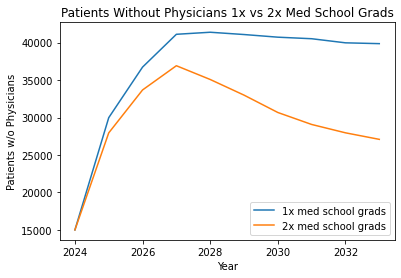

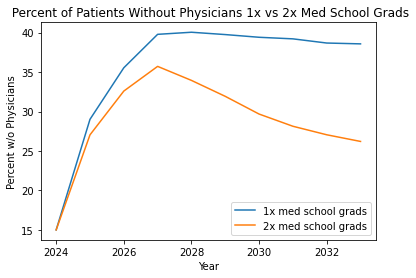

In [89]:
sit2_prc_percent_wo_phys = np.array(sit2_percent_wo_phys)*100

plt.figure()
plt.title('Patients Without Physicians 1x vs 2x Med School Grads')
plt.xlabel('Year')
plt.ylabel('Patients w/o Physicians')
plt.plot(years, np.mean(pats_wo_phys, axis=0), label='1x med school grads')
plt.plot(years, np.mean(sit2_pats_wo_phys, axis=0), label='2x med school grads')
plt.legend()

plt.figure()
plt.title(' Percent of Patients Without Physicians 1x vs 2x Med School Grads')
plt.xlabel('Year')
plt.ylabel('Percent w/o Physicians')
plt.plot(years, np.mean(prc_percent_wo_phys, axis=0), label='1x med school grads')
plt.plot(years, np.mean(sit2_prc_percent_wo_phys, axis=0), label='2x med school grads')
plt.legend()

plt.show()